In [1]:
import sys  
sys.path.insert(0, r'C:\Users\marci\Desktop\Python\Numba-tutorial')
import numpy as np
import matplotlib.pyplot as plt
from numba import int64, int32, float64, float32, cuda, guvectorize

In [3]:
from FractionalAbundance import FractionalAbundance

In [4]:
FA = FractionalAbundance(element="He", concurrent=True)

In [5]:
K = FA.K

In [6]:
FA_output = np.zeros_like(K)

In [7]:
for i in range(K.shape[2]):
    for j in range(K.shape[1]):
        sum_all = 0
        current_product = K[0,j,i]
        product_all = []
        for k in range(K.shape[0]):
            current_product *= K[k,j,i]
            sum_all += current_product
            product_all.append(current_product)
        for k in range(K.shape[0]):    
            FA_output[k,j,i] = product_all[k]/sum_all
        

In [8]:
(FA_output == K).all()

False

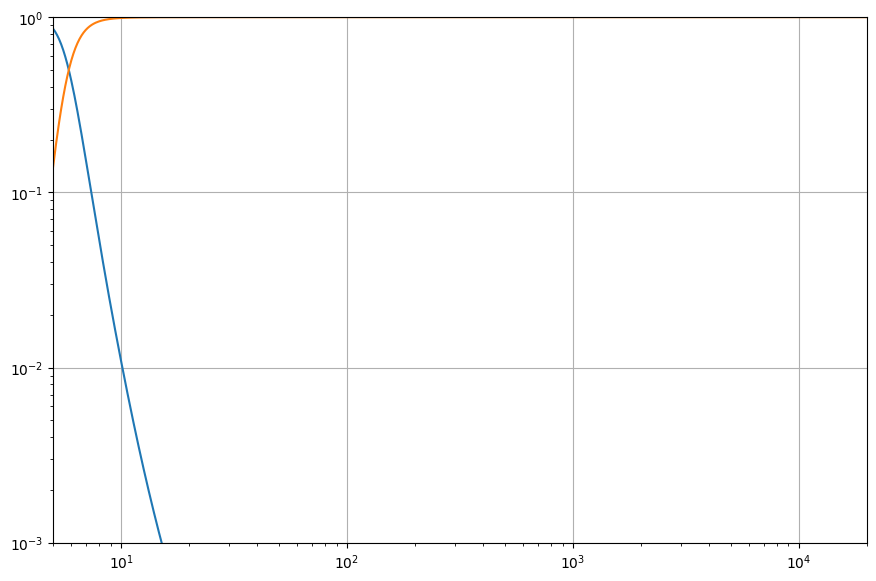

In [9]:
for ion in range(FA.Z):
    plt.plot(FA.Te_new, FA_output[ion+1,:,50])
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim((10**-3, 10**0))
    plt.xlim((5, 20000))
plt.grid()

### Numba

In [70]:
import math
from numba import cuda
import math 
from numba import float32 
from pdb import set_trace

In [71]:
array = K.copy()

In [72]:
threadsperblock = (1, 32, 32)
blockspergrid_x = math.ceil(array.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(array.shape[1] / threadsperblock[1])
blockspergrid_z = math.ceil(array.shape[2] / threadsperblock[2])
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
print(blockspergrid)
print(threadsperblock)
print(array.shape)

(3, 25, 4)
(1, 32, 32)
(3, 800, 100)


In [81]:
@cuda.jit
def increment_a_2D_array(X,Y):
    cuda.syncthreads()
    k, j, i = cuda.grid(3)
    if i < X.shape[2] and j < X.shape[1] and k < X.shape[0]:
        sum_all = 0
        current_product = 1
        cuda.syncthreads()
        for k in range(X.shape[0]):
            current_product *= X[k,j,i]
            sum_all += current_product
            Y[k, j, i] = current_product
            cuda.syncthreads()
        for k in range(X.shape[0]):
            Y[k, j, i] = Y[k, j, i] / sum_all
            cuda.syncthreads()
    cuda.syncthreads()

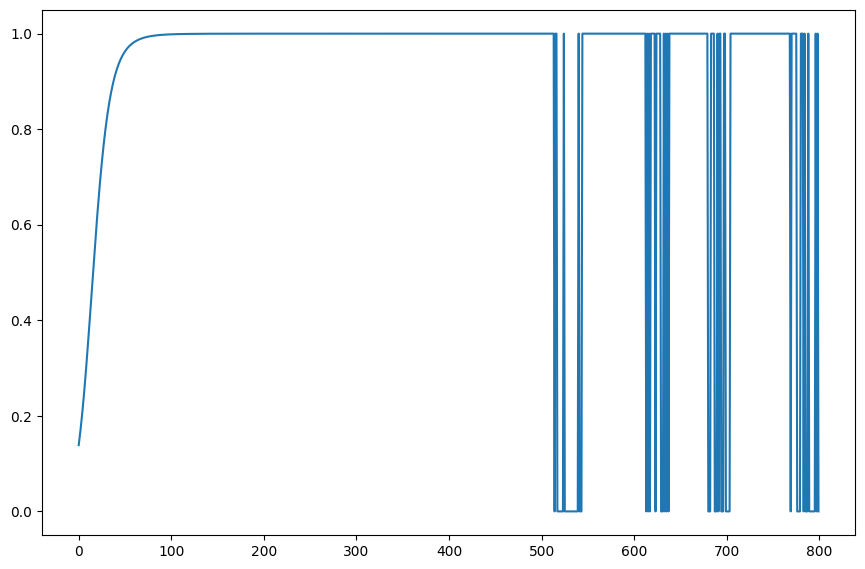

In [82]:
# X array
device_array = cuda.to_device((array).astype(np.float32))
# Y array
result_array = cuda.to_device(np.ones_like(array).astype(np.float32))
increment_a_2D_array[blockspergrid, threadsperblock](device_array,
                                                     result_array)
result_gpu = result_array.copy_to_host()
plt.plot(result_gpu[2,: ,50]);

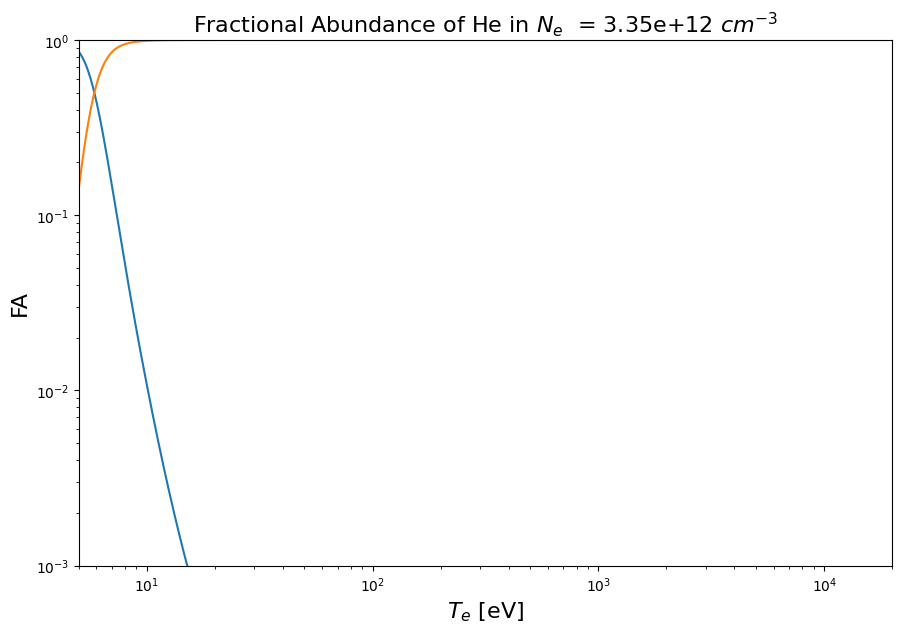

In [15]:
FA.plot_FA_all()

In [52]:
from numba import cuda
import math 
from numba import float32 
@cuda.jit
def increment_a_2D_array(X,Y):
    cuda.syncthreads()
    k, j, i = cuda.grid(3)
    if i < X.shape[2] and j < X.shape[1]:
        sum_all = 0
        current_product = 1
        cuda.syncthreads()
        for k in range(X.shape[0]):
            current_product *= X[k,j,i]
            sum_all += current_product
            Y[k, j, i] = current_product
        cuda.syncthreads()    
        for k in range(X.shape[0]):
            Y[k, j, i] = Y[k, j, i] / sum_all
            

In [51]:
cuda.cudadrv.devices._DeviceList

numba.cuda.cudadrv.devices._DeviceList